In [15]:
import torch
import torchvision
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [8]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [9]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [10]:
example_data.shape

torch.Size([1000, 1, 28, 28])

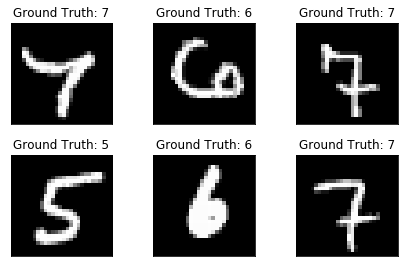

In [13]:

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])


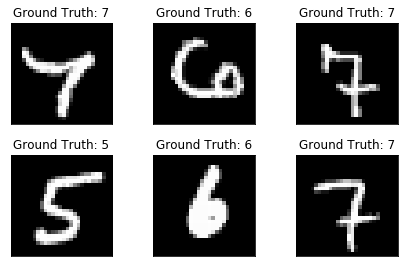

In [14]:
fig

### Network
We'll use two 2-D convolutional layers followed by two fully-connected (or linear) layers. As activation function we'll choose rectified linear units (ReLUs in short) and as a means of regularization we'll use two dropout layers.

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [17]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [18]:
#Plotting loss 
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [22]:
#Train
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './results/model.pth')
      torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [23]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [25]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

C:\Users\User\AppData\Local\Continuum\anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.2975, Accuracy: 844/10000 (8%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.345037
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.256796
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.295717
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.245368
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.247254
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.221046
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.112719
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.171144
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.103487
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.878651
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.901978
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.015805
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.696556
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.475158
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.728809
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.515937
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.277941
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.407211
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.197148
Train Epoch: 1 [12160/6

Text(0, 0.5, 'negative log likelihood loss')

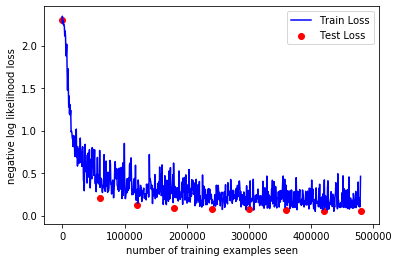

In [49]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses[2:], color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')


In [28]:
with torch.no_grad():
  output = network(example_data)

C:\Users\User\AppData\Local\Continuum\anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


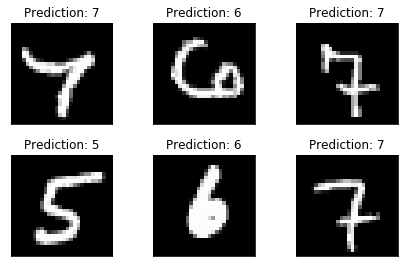

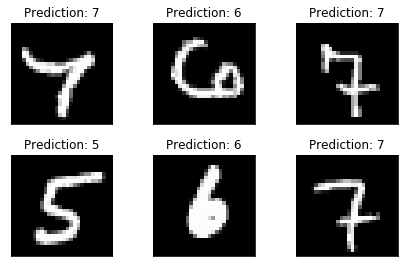

In [29]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

### Continued Training 

In [33]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [35]:
network_state_dict = torch.load("./results/model.pth")
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load("./results/optimizer.pth")
continued_optimizer.load_state_dict(optimizer_state_dict)

In [36]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

C:\Users\User\AppData\Local\Continuum\anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.300598
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.214103
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.342199
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.299901
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.211190
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.280692
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.209811
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.329057
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.243939
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.203843
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.170794
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.242920
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.525173
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.318758
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.196778
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.190813
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.242994
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.217600
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.286199
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.232871
Train Epoch: 4 [12800/60000 (

C:\Users\User\AppData\Local\Continuum\anaconda3\envs\fastai\lib\site-packages\torch\nn\_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0819, Accuracy: 9760/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.192501
Train Epoch: 5 [640/60000 (1%)]	Loss: 0.137968
Train Epoch: 5 [1280/60000 (2%)]	Loss: 0.183286
Train Epoch: 5 [1920/60000 (3%)]	Loss: 0.153384
Train Epoch: 5 [2560/60000 (4%)]	Loss: 0.160002
Train Epoch: 5 [3200/60000 (5%)]	Loss: 0.163597
Train Epoch: 5 [3840/60000 (6%)]	Loss: 0.113800
Train Epoch: 5 [4480/60000 (7%)]	Loss: 0.150868
Train Epoch: 5 [5120/60000 (9%)]	Loss: 0.244743
Train Epoch: 5 [5760/60000 (10%)]	Loss: 0.129244
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.111085
Train Epoch: 5 [7040/60000 (12%)]	Loss: 0.221634
Train Epoch: 5 [7680/60000 (13%)]	Loss: 0.357162
Train Epoch: 5 [8320/60000 (14%)]	Loss: 0.275101
Train Epoch: 5 [8960/60000 (15%)]	Loss: 0.132903
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0.237195
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.356414
Train Epoch: 5 [10880/60000 (18%)]	Loss: 0.331978
Train Epoch: 5 [11520/60000 (19%)]	Loss: 0.200137
Train Epoch: 5 [12160

Train Epoch: 8 [26880/60000 (45%)]	Loss: 0.094763
Train Epoch: 8 [27520/60000 (46%)]	Loss: 0.121899
Train Epoch: 8 [28160/60000 (47%)]	Loss: 0.154853
Train Epoch: 8 [28800/60000 (48%)]	Loss: 0.101319
Train Epoch: 8 [29440/60000 (49%)]	Loss: 0.212994
Train Epoch: 8 [30080/60000 (50%)]	Loss: 0.270805
Train Epoch: 8 [30720/60000 (51%)]	Loss: 0.195825
Train Epoch: 8 [31360/60000 (52%)]	Loss: 0.467851
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.095748
Train Epoch: 8 [32640/60000 (54%)]	Loss: 0.319125
Train Epoch: 8 [33280/60000 (55%)]	Loss: 0.269563
Train Epoch: 8 [33920/60000 (57%)]	Loss: 0.100764
Train Epoch: 8 [34560/60000 (58%)]	Loss: 0.127815
Train Epoch: 8 [35200/60000 (59%)]	Loss: 0.113472
Train Epoch: 8 [35840/60000 (60%)]	Loss: 0.299055
Train Epoch: 8 [36480/60000 (61%)]	Loss: 0.092671
Train Epoch: 8 [37120/60000 (62%)]	Loss: 0.125135
Train Epoch: 8 [37760/60000 (63%)]	Loss: 0.163285
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.302190
Train Epoch: 8 [39040/60000 (65%)]	Loss: 0.082459


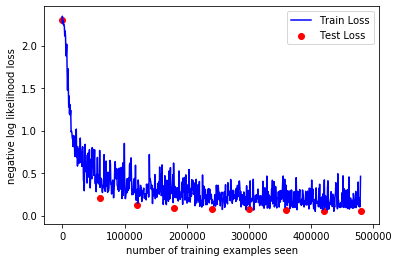

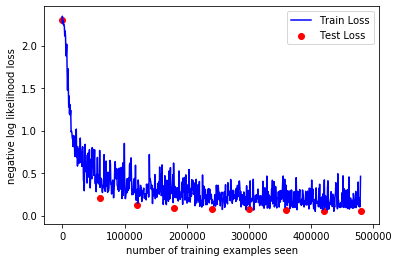

In [48]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses[2:], color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [47]:
print(test_counter)
print(test_losses[2:])

[0, 60000, 120000, 180000, 240000, 300000, 360000, 420000, 480000]
[2.29751767578125, 0.2012617218017578, 0.12693386154174804, 0.09354338455200195, 0.08193508911132813, 0.07348155212402344, 0.06520756187438966, 0.05977743606567383, 0.05450869750976563]


In [44]:
print(len(train_counter))
print(len(train_losses))

754
754
